<a href="https://colab.research.google.com/github/ThomasL642/Generative-Adversarial-Networks/blob/main/Eye_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from glob import glob
import keras

In [ ]:
IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 100
noise_dim = 64
dir = "/content/drive/MyDrive/eyes"
IMG_SIZE = 128

100%|██████████| 3662/3662 [28:54<00:00,  2.11it/s]


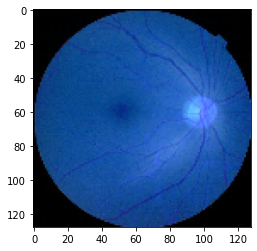

[[[2 2 2]
  [2 1 3]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [2 1 3]
  [1 0 2]
  ...
  [2 1 3]
  [1 1 1]
  [1 1 1]]

 [[2 2 2]
  [0 0 0]
  [3 2 4]
  ...
  [1 1 1]
  [1 1 1]
  [1 0 2]]

 ...

 [[0 0 0]
  [1 1 1]
  [1 1 1]
  ...
  [2 2 2]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]
Number of examples:  3662
Shape of the images: (128, 128, 3)


In [ ]:
from tqdm import tqdm
data = []

def create_data():
    path = dir
    for img in tqdm(os.listdir(path)):
      img_array = cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
      data.append(new_array)
    plt.imshow(data[0])
    plt.show()
    print(new_array)

create_data()

train_images = data

print(f"Number of examples:  {len(train_images)}")
print(f"Shape of the images: {np.asarray(train_images).shape[1:]}")

train_images = (np.asarray(train_images).astype(np.float32) - 127.5)/127.5

In [ ]:
def conv_l(
    x,
    filters,
    activation,
    kernel_size=(3,3),
    strides=(1,1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
      x =layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
      x = layers.Dropout(drop_value)(x)
    return x

def get_discriminator_model():
  img_input = layers.Input(shape=IMG_SHAPE)
  x = layers.ZeroPadding2D((2, 2))(img_input)
  x = conv_l(
      x,
      64,
      kernel_size = (5,5),
      strides=(2,2),
      use_bn=False,
      use_bias=True,
      activation=layers.LeakyReLU(0.2),
      use_dropout=False,
      drop_value=0.3,
  )
  x = conv_l(
      x,
      128,
      kernel_size = (5,5),
      strides=(2,2),
      use_bn=False,
      activation=layers.LeakyReLU(0.2),
      use_bias=True,
      use_dropout=True,
      drop_value=0.3,
  )
  x = conv_l(
      x,
      256,
      kernel_size = (5,5),
      strides=(2,2),
      use_bn=False,
      activation=layers.LeakyReLU(0.2),
      use_bias=True,
      use_dropout=True,
      drop_value=0.3,
  )
  x = conv_l(
      x,
      512,
      kernel_size = (5,5),
      strides=(2,2),
      use_bn=False,
      activation=layers.LeakyReLU(0.2),
      use_bias=True,
      use_dropout=False,
      drop_value=0.3,
  )
    
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)

  d_model = keras.models.Model(img_input, x, name="discriminator")
  return d_model

d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 132, 132, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 66, 66, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33, 33, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 128)     

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3,3),
    strides=(1,1),
    up_size=(2,2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
      x = layers.BatchNormalization()(x)

    if activation:
      x = activation(x)
    if use_dropout:
      x = layers.Dropout(drop_value)(x)
    return x

def get_generator_model():
  noise = layers.Input(shape=(noise_dim,))
  x = layers.Dense(4 * 4 * 512, use_bias=False)(noise)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Reshape((4, 4, 512))(x)
  x = upsample_block(
      x,
      128,
      layers.LeakyReLU(0.2),
      strides=(1, 1),
      use_bias = False,
      use_bn=True,
      padding="same",
      use_dropout=False,
  )
  x = upsample_block(
      x,
      64,
      layers.LeakyReLU(0.2),
      strides=(1,1),
      use_bias=False,
      use_bn=True,
      padding="same",
      use_dropout=False,
  )
  x = upsample_block(
      x,
      32,
      layers.LeakyReLU(0.2),
      strides=(1,1),
      use_bias=False,
      use_bn=True,
      padding="same",
      use_dropout=False,
  )
  x = upsample_block(
      x,
      16,
      layers.LeakyReLU(0.2),
      strides=(1,1),
      use_bias=False,
      use_bn=True,
      padding="same",
      use_dropout=False,
  )
  x = upsample_block(
      x, 3, layers.Activation("tanh"), strides=(1,1), use_bias=False, use_bn=True
  )

  g_model = keras.models.Model(noise, x, name="generator")
  return g_model

g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         58

In [ ]:
class WGAN(keras.Model):
  def __init__(
      self,
      discriminator,
      generator,
      latent_dim,
      discriminator_extra_steps=3,
      gp_weight=10.0,

  ):
      super(WGAN, self).__init__()
      self.discriminator = discriminator
      self.generator = generator
      self.latent_dim = latent_dim
      self.d_steps = discriminator_extra_steps
      self.gp_weight = gp_weight
    
  def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
    super(WGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.d_loss_fn = d_loss_fn
    self.g_loss_fn = g_loss_fn

  def gradient_penalty(self, batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      pred = self.discriminator(interpolated, training=True)
      
    grads = gp_tape.gradient(pred, [interpolated])[0]

    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]
    batch_size = tf.shape(real_images)[0]

    for i in range(self.d_steps):
      random_latent_vectors = tf.random.normal(
          shape=(batch_size, self.latent_dim)
      )
      with tf.GradientTape() as tape:

        fake_images = self.generator(random_latent_vectors, training=True)

        fake_logits = self.discriminator(fake_images, training=True)
        real_logits = self.discriminator(real_images, training=True)

        d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)

        gp = self.gradient_penalty(batch_size, real_images, fake_images)

        d_loss = d_cost + gp * self.gp_weight

      d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
      self.d_optimizer.apply_gradients(
          zip(d_gradient, self.discriminator.trainable_variables)
      )

      random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
      with tf.GradientTape() as tape:
        generated_images = self.generator(random_latent_vectors, training=True)
        gen_img_logits = self.discriminator(generated_images, training=True)
        g_loss = self.g_loss_fn(gen_img_logits)

      gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(
          zip(gen_gradient, self.generator.trainable_variables)
      )

      return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=6, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images = (generated_images * 127.5) + 127.5

    for i in range(self.num_img):
      img = generated_images[i].numpy()
      img = keras.preprocessing.image.array_to_img(img)
      img.save("generated_img_{i}_{epoch}.png". format(i=i, epoch=epoch))

In [ ]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

def discriminator_loss(real_img, fake_img):
  real_loss = tf.reduce_mean(real_img)
  fake_loss = tf.reduce_mean(fake_img)
  return fake_loss - real_loss

def generator_loss(fake_img):
  return -tf.reduce_mean(fake_img)

epochs = 800

cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

wgan = WGAN(
    discriminator= d_model,
    generator = g_model,
    latent_dim = noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer = discriminator_optimizer,
    g_optimizer = generator_optimizer,
    g_loss_fn = generator_loss,
    d_loss_fn = discriminator_loss,
)

wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/800
37/37 [==============================] - 39s 785ms/step - d_loss: -296.3836 - g_loss: 54.5261
Epoch 2/800
37/37 [==============================] - 29s 782ms/step - d_loss: -350.0772 - g_loss: -75.4435
Epoch 3/800
37/37 [==============================] - 29s 795ms/step - d_loss: -335.2674 - g_loss: -117.1457
Epoch 4/800
37/37 [==============================] - 30s 807ms/step - d_loss: -327.7891 - g_loss: -138.3350
Epoch 5/800
37/37 [==============================] - 30s 817ms/step - d_loss: -318.1834 - g_loss: -161.4846
Epoch 6/800
37/37 [==============================] - 30s 824ms/step - d_loss: -313.9167 - g_loss: -168.4250
Epoch 7/800
37/37 [==============================] - 31s 830ms/step - d_loss: -312.3781 - g_loss: -142.1030
Epoch 8/800
37/37 [==============================] - 31s 834ms/step - d_loss: -320.1889 - g_loss: -64.8016
Epoch 9/800
37/37 [==============================] - 31s 831ms/step - d_loss: -314.1809 - g_loss: 34.1212
Epoch 10/800
37/37 [==============

In [ ]:
from IPython.display import Image, display

display(Image("generated_img_0_19.png"))
display(Image("generated_img_1_19.png"))
display(Image("generated_img_2_19.png"))

display(Image("generated_img_0_100.png"))
display(Image("generated_img_1_100.png"))
display(Image("generated_img_2_100.png"))

display(Image("generated_img_0_500.png"))
display(Image("generated_img_1_500.png"))
display(Image("generated_img_2_500.png"))

display(Image("generated_img_0_699.png"))
display(Image("generated_img_1_699.png"))
display(Image("generated_img_2_699.png"))

display(Image("generated_img_0_799.png"))
display(Image("generated_img_1_799.png"))
display(Image("generated_img_2_799.png"))

display(Image("generated_img_0_999.png"))
display(Image("generated_img_1_999.png"))
display(Image("generated_img_2_999.png"))
